# 데이터 다운로드

In [16]:
# !wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

In [17]:
# !unzip -qq cats_and_dogs_filtered.zip

In [18]:
# 패키지 임포트
import os
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image

In [19]:
# pytorch 버전 확인
import torch
print(torch.__version__)

1.13.1+cu117


In [20]:
#GPU 사용체크
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

# 파이토치 데이터셋 클래스

In [27]:
# 데이터세트 정의 클래스
class PytorchCustomDataset(Dataset):
    def __init__(self
                 , root_dir ="C:\\Users\\vivid\\Desktop\\DAT\\2024-1\\cats_and_dogs_filtered\\train"
                 , transform = None):
        self.image_abs_path = root_dir
        self.transform = transform
        self.label_list = os.listdir(self.image_abs_path) # 'root_dir'내의 모든 서브디렉토리의 이름을 저장하는 리스트. 
        self.label_list.sort() #클래스 레이블별로 정렬 (cat, dog....)
        self.x_list = [] # 이미지 파일의 경로
        self.y_list = [] # 이미지의 레이블 인덱스
        for label_index, label_str in enumerate(self.label_list): #self.label_list는 각 레이블(클래스 이름과 인덱스를 순회) index는 이미지, str은 클래스(레이블)
            img_path = os.path.join(self.image_abs_path, label_str)
            img_list = os.listdir(img_path)
            for img in img_list:
                self.x_list.append(os.path.join(img_path, img))
                self.y_list.append(label_index)
        pass
    '''
    self.x_list = ['/content/cats_and_dogs_filtered/train/cats/cat001.jpg',
                   '/content/cats_and_dogs_filtered/train/cats/cat002.jpg',
                   ..., '/content/cats_and_dogs_filtered/train/dogs/dog003.jpg']
    self.y_list = [0, 0, ..., 1]

    
    '''

    def __len__(self):
        return len(self.x_list) #데이터의 전체 크기 반환
    
    def __getitem__(self, idx): #데이터셋에서 특정 인덱스(idx)에 해당하는 데이터(레이블) 반환
        image = Image.open(self.x_list[idx]) #idx번째 이미지
        if image.mode is not "RGB": #RGB아니면 RGB로 변환하기
            image = image.convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, self.y_list[idx] #이미지와 레이블 반환
    
    # 클래스 레이블의 목록을 텍스트 파일로 저장
    def __save_label_map__(self, dst_text_path = 'label_map.txt'): #dst_text_path는 저장할 파일의 경로
        label_list = self.label_list
        f = open(dst_text_path, 'w') 
        for i in range(len(label_list)):
            f.write(label_list[i] + '\n')
        f.close()
        pass
    
    # 클래스(레이블)의 총 수 반환
    def __num_classes__(self):
        return len(self.label_list)


# Model

In [22]:
#네트워크 정의
import torch
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

class MODEL(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = models.resnet18(pretrained=True) #사전훈련된 resnet18 (pretrained=true는 사전 훈련된 가중치 사용)
        # 최종 뷴리를 위한 추가적인 레이어 정의
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(1000, num_classes), #1000개에서 num_classes개수로 줄임
            nn.Sigmoid() #각 입력에 대해서 Sigmoid함수 적용(적용해도 출력 차원의 개수는 변하지않음)
        )
    # 선형 레이어의 입력 차원은 ResNet-18으; 마지막 레이어 출력 차원에 맞춰야함. 출력 차원은 분류하려는 클래스의 수(num_classes)와 일치
    
    def forward(self, x): #x는 모델의 입력 데이터
        x = self.network(x) #x값이 모델의 여러 계층을 통과하며 처리되어, 중간 표현으로 변환
        return self.classifier(x) # 사용자가 정의한 분류기가 중간 표현인 x를 받아 최종 예측

# main 함수

In [23]:
# # 훈련 메인 함수 정의
# import torch
# import torch.optim as optim

# train_losses, train_accuracy = [], []
# val_losses, val_accuracy = [], []

# def trainmain():
#     USE_CUDA = torch.cuda.is_available()
#     DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
#     img_width, img_height = 224, 224
#     EPOCHS = 12
#     BATCH_SIZE = 32

#     #데이터세트 로딩
#     transform_train = transforms.Compose([
#         transforms.Resize(size=(img_width, img_height)),
#         transforms.RandomRotation(degrees=15),
#         transforms.ToTensor()
#     ])
#     transform_test = transforms.Compose([
#         transforms.Resize(size=(img_width, img_height)),
#         transforms.ToTensor()
#     ])
#     TrainDataset = PytorchCustomDataset
#     TestDataset = PytorchCustomDataset
#     train_data = TrainDataset(root_dir = './cats_and_dogs_filtered/train', transform = transform_train)
#     test_data = TrainDataset(root_dir = './cats_and_dogs_filtered/train', transform = transform_test)
#     train_loader = torch.utils.data.DataLoader(
#         train_data,
#         batch_size=BATCH_SIZE,
#         shuffle=True
#     )
#     test_loader = torch.utils.data.DataLoader(
#         test_data,
#         batch_size=BATCH_SIZE,
#         shuffle=True
#     )
#     train_data.__save_label_map__()
#     num_classes = train_data.__num_classes__()

#     #모델 객체 생성. PyTorch_Classification_Model.pt 모델 파일명 지정
#     model = MODEL(num_classes).to(DEVICE)
#     model_str = 'PyTorch_Classififcation_Model'
#     model_str += ".pt"

#     #최적화 함수와 학습률 지정
#     #optimizer = optim.Adam(model.parameters(), lr=0.0001)
#     #schduler = optim.lr_schduler.StepLR(optimizer, stop_size=50, gamma=0.1)
#     optimizer = optim.Adam(model.parameters(), lr=0.0001)
#     scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

#     #에포크 만큼 훈련, 검증
#     for epoch in range(1, EPOCHS+1):
#         model.train()
#         tr_loss = 0.0
#         tr_correct = 0.0
#         for data, target in (train_loader):
#             data, target = data.to(DEVICE), target.to(DEVICE)
#             optimizer.zero_grad()
#             output = model(data)
#             loss = F.cross_entropy(output, target)
#             tr_loss += F.nll_loss(output, target, rduction='sum').item()
#             pred = output.data.max(dim=1, keepdim=True)[1]
#             tr_correct += pred.eq(target.view_as(pred)).sum().item()
#             loss.backward()
#             optimizer.step()
#         scheduler.step()
#         tr_ep_loss = tr_loss/len(train_loader.dataset)
#         tr_ep_accuracy = 100 * tr_correct/len(train_loader.dataset)

#         model.eval()
#         te_loss=0
#         te_correct = 0
#         with torch.no_grad():
#             for data, target in (test_loader):
#                 data, target = data.to(DEVICE), target.to(DEVICE)
#                 output = F.cross_entropy(output, target)
#                 te_loss += F.cross_entropy(output, target, reduction='sum').item()
#                 pred = output.max(1, keepdim = True)[1]
#                 te_correct += pred.eq(target.view_as(pred)).sum().item()
#         te_ep_loss = te_loss / len(test_loader.dataset)
#         te_ep_accuracy = 100 * te_correct / len(test_loader.dataset)
#         print('[{}] Train Loss: {:.4f}, Train Accuracy: {:.2f}% Test Loss: {:4.f}, Test Accuracy: {:.2f}%'.format(
#             epoch, tr_ep_loss, tr_ep_accuracy, te_ep_loss, te_ep_accuracy))
#         ))
# 이어서하기!!

In [28]:
# 훈련 메인 함수 정의
import torch
import torch.optim as optim

train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]

def trainmain():
    USE_CUDA = torch.cuda.is_available()
    DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
    img_width, img_height = 224, 224
    EPOCHS     = 12
    BATCH_SIZE = 32

    #데이터세트 로딩
    # 이미지 데이터에 적용할 전처리 단계 정의
    transform_train = transforms.Compose([
                transforms.Resize(size=(img_width, img_height)) #데이터 전처리
                , transforms.RandomRotation(degrees=15) #같은 이미지가 훈련 과정에서 여러번 사용될 때마다 조금씩 다르게 보임
                , transforms.ToTensor() #모델에 넣을 형식으로 픽셀값 [0.1]
                ])
    transform_test = transforms.Compose([
                transforms.Resize(size=(img_width, img_height))
                , transforms.ToTensor()
                ])
    TrainDataset = PytorchCustomDataset
    TestDataset = PytorchCustomDataset
    train_data = TrainDataset(root_dir = './cats_and_dogs_filtered/train', transform = transform_train)
    test_data = TrainDataset(root_dir = './cats_and_dogs_filtered/train', transform = transform_test)
    train_loader = torch.utils.data.DataLoader(
        train_data
        , batch_size=BATCH_SIZE
        , shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_data
        , batch_size=BATCH_SIZE
        , shuffle=True
    )
    train_data.__save_label_map__() # 클래스 레이블을 텍스트 파일에 저장
    num_classes = train_data.__num_classes__() #고유한 클래스의 수 반환

    #모델 객체 생성, PyTorch_Classification_Model.pt 모델 파일명 지정
    model = MODEL(num_classes).to(DEVICE)
    model_str = "PyTorch_Classification_Model"
    model_str += ".pt" #모델의 상태 사전을 저장할 때 사용되는 형식 (모델의 파라미터(가중치 및 편향)을 포함하는 사전)
    # torch.save(model.state_dict(), model_str) #이렇게 하면 모델 가중치 보존

    #최적화 함수와 학습률 지정
    #optimizer = optim.Adam(model.parameters(), lr=0.0001)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)# parameer은 모델의 학습 가능한 파라미터(가중치, 편향)반환.
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    # scheduler은 학습 과정 동안 옵티마이저의 학습률을 조정하는데 사용, 학습률을 gamma 비율로 감소시키는 스케줄러
    acc = 0.0

    # 에포크 만큼 훈련, 검증
    for epoch in range(1, EPOCHS + 1):
        model.train()
        tr_loss = 0.0
        tr_correct = 0.0
        for data, target in (train_loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad() #훈련할 때는 optimizer 0으로 초기화
            output = model(data) #모델을 통해서 예측
            loss = F.cross_entropy(output, target) #손실계산
            tr_loss += F.nll_loss(output,target,reduction='sum').item() #손실 계산하고 누적
            pred = output.data.max(dim=1,keepdim=True)[1] # 가장 높은 값을 가진 인덱스를 예측 레이블
            tr_correct += pred.eq(target.view_as(pred)).sum().item() #예측이 정확하면 누적
            loss.backward() #파라미터 손실의 그레디언트 계산
            optimizer.step() #그레디언트를 사용하여 모델의 파라미터 업데이트
        scheduler.step() #한 에포크의 훈련이 끝나면 학습률 스케줄러러의 .step()으로 학습률 조정. step_size마다 학습률을 gamma 비율로 감소시킴
        tr_ep_loss = tr_loss/len(train_loader.dataset)
        tr_ep_accuracy = 100. * tr_correct/len(train_loader.dataset)

        model.eval()
        te_loss = 0
        te_correct = 0
        with torch.no_grad():
            for data, target in (test_loader):
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data)
                loss = F.cross_entropy(output, target)
                te_loss += F.cross_entropy(output, target, reduction='sum').item()
                pred = output.max(1, keepdim=True)[1]
                te_correct += pred.eq(target.view_as(pred)).sum().item()
        te_ep_loss = te_loss / len(test_loader.dataset)
        te_ep_accuracy = 100. * te_correct / len(test_loader.dataset)
        print('[{}] Train Loss: {:.4f}, Train Accuracy: {:.2f}% Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(
                epoch, tr_ep_loss, tr_ep_accuracy, te_ep_loss, te_ep_accuracy))


# 모델이 훈련 과정에서 새로운 최고 성능을 달성할 때마다 해당 모델을 저장하여, 훈련이 끝난 후 가장 좋은 성능을 보인 모델 사용
        if acc < te_ep_accuracy:
            acc = te_ep_accuracy
            torch.save(model.state_dict(), model_str)
            print("model saved!")

        train_losses.append(tr_ep_loss)
        train_accuracy.append(tr_ep_accuracy)
        val_losses.append(te_ep_loss)
        val_accuracy.append(te_ep_accuracy)


In [29]:
# 훈련 메인 함수 호출
trainmain()

c:\Users\vivid\AppData\Local\Programs\Python\Python37\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\vivid\AppData\Local\Programs\Python\Python37\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\vivid/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

[1] Train Loss: -0.8875, Train Accuracy: 92.45% Test Loss: 0.3343, Test Accuracy: 98.00%
model saved!
[2] Train Loss: -0.9748, Train Accuracy: 98.30% Test Loss: 0.3226, Test Accuracy: 99.10%
model saved!
[3] Train Loss: -0.9786, Train Accuracy: 98.40% Test Loss: 0.3154, Test Accuracy: 99.85%
model saved!
[4] Train Loss: -0.9893, Train Accuracy: 99.15% Test Loss: 0.3138, Test Accuracy: 99.95%
model saved!
[5] Train Loss: -0.9888, Train Accuracy: 99.20% Test Loss: 0.3264, Test Accuracy: 98.80%
[6] Train Loss: -0.9883, Train Accuracy: 98.90% Test Loss: 0.3144, Test Accuracy: 99.90%
[7] Train Loss: -0.9942, Train Accuracy: 99.60% Test Loss: 0.3145, Test Accuracy: 99.90%
[8] Train Loss: -0.9924, Train Accuracy: 99.45% Test Loss: 0.3140, Test Accuracy: 99.95%
[9] Train Loss: -0.9893, Train Accuracy: 99.05% Test Loss: 0.3146, Test Accuracy: 99.90%
[10] Train Loss: -0.9879, Train Accuracy: 98.95% Test Loss: 0.3148, Test Accuracy: 99.95%
[11] Train Loss: -0.9948, Train Accuracy: 99.60% Test Los

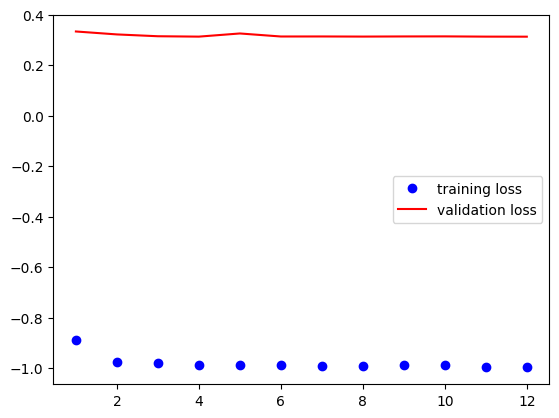

In [30]:
# 훈련 데이터와 검증 데이터의 손실 그래프
import matplotlib.pyplot as plt

plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

'ls'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


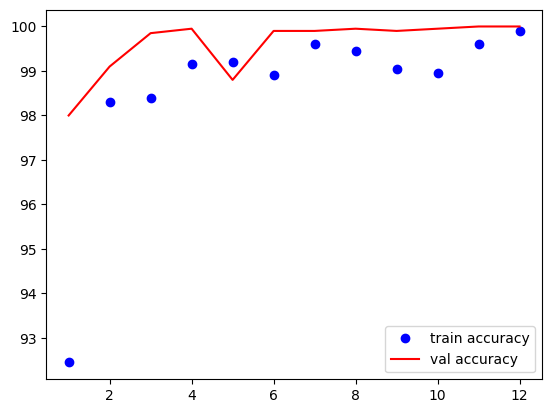

In [31]:
# 훈련 데이터와 검증 데이터의 정확도 그래프
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()
     

# PyTorch_Classification_Model.pt 모델 파일 확인
!ls

이미지 분류 모델 추론 테스트

./cats_and_dogs_filtered/validation/cats/cat.2010.jpg
./cats_and_dogs_filtered/validation/dogs/dog.2001.jpg
./cats_and_dogs_filtered/validation/cats/cat.2010.jpg


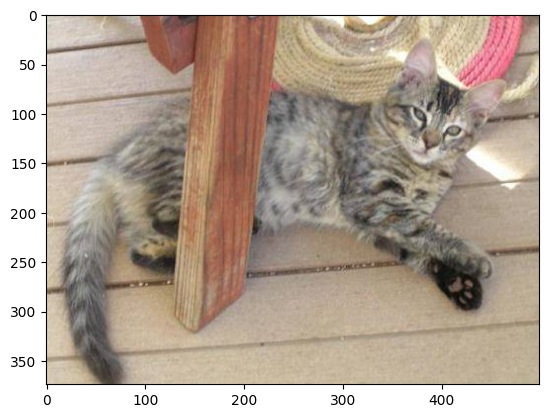

./cats_and_dogs_filtered/validation/dogs/dog.2001.jpg


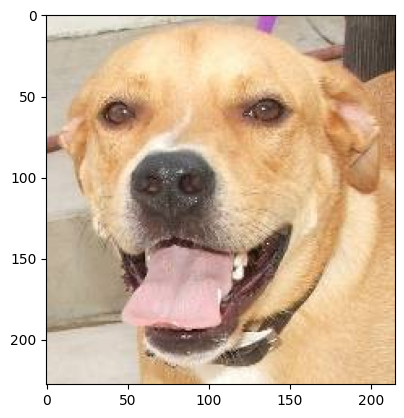

c:\Users\vivid\AppData\Local\Programs\Python\Python37\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\vivid\AppData\Local\Programs\Python\Python37\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


./cats_and_dogs_filtered/validation/cats/cat.2010.jpg
[[1.0000000e+00 3.1161844e-09]]
cats


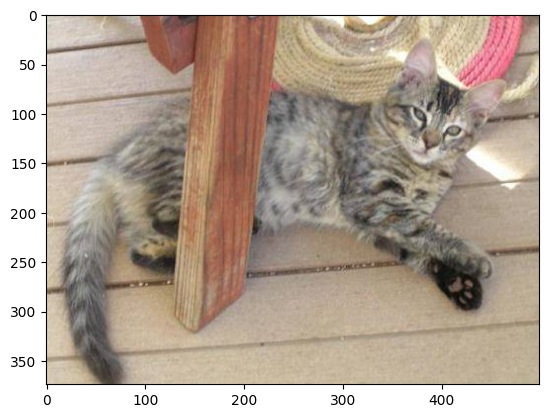

./cats_and_dogs_filtered/validation/dogs/dog.2001.jpg
[[1.4469686e-07 9.9999988e-01]]
dogs


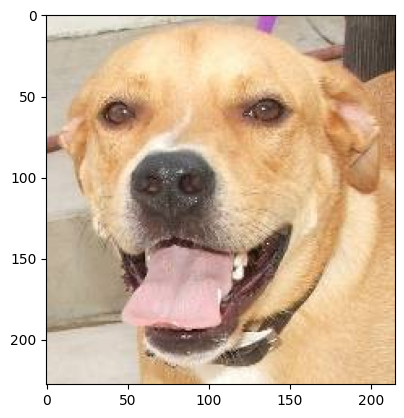

In [33]:
# 테스트 이미지 로딩
import os
PATH = "./cats_and_dogs_filtered/validation"
validation_cats_dir = PATH + '/cats'  # directory with our validation cat pictures
validation_dogs_dir = PATH + '/dogs'  # directory with our validation dog pictures
list_of_test_cats_images = os.listdir(validation_cats_dir)
list_of_test_dogs_images = os.listdir(validation_dogs_dir)
for idx in range(len(list_of_test_cats_images)):
    list_of_test_cats_images[idx] = validation_cats_dir + '/'+list_of_test_cats_images[idx]
for idx in range(len(list_of_test_dogs_images)):
    list_of_test_dogs_images[idx] = validation_dogs_dir + '/'+list_of_test_dogs_images[idx]
list_of_test_images = list_of_test_cats_images + list_of_test_dogs_images
     

# 로딩된 이미지 경로 프린트
print(list_of_test_cats_images[10])
print(list_of_test_images[501])
     

# 이미지 보여주는 함수, 이미지 추론 함수

from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

#라벨맵 로딩 함수
def load_label_map(textFile):
    return np.loadtxt(textFile, str, delimiter='\t')

#이미지 읽는 함수
def cv_image_read(image_path):
    print(image_path)
    return cv2.imread(image_path)

#이미지 보여주는 함수
def show_image(cv_image):
    rgb = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(rgb)
    plt.show()

#이미지를 분류 모델로 추론한 결과를 텍스트로 보여주는 함수
def print_result(inference_result, class_map):
    class_text = class_map[np.argmax(inference_result)]
    print(inference_result)
    print(class_text)

#이미지를 분류 모델로 추론하는 함수
def inference_image(opencv_image, transform_info, model, DEVICE):
    image = Image.fromarray(opencv_image)
    image_tensor = transform_info(image) #이미지 증강
    image_tensor = image_tensor.unsqueeze(0) #이미지 텐서에 배치 차원 추가
    image_tensor = image_tensor.to(DEVICE)
    result = model(image_tensor)
    return result
     

# 이미지 보여주는 함수 실습
show_image(cv_image_read(list_of_test_images[10]))
show_image(cv_image_read(list_of_test_images[501]))
     

# 테스트 메인 함수
import os
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

def testmain(image_path):
    USE_CUDA = torch.cuda.is_available()
    DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

    img_width, img_height = 224, 224
    transform_info = transforms.Compose([
                transforms.Resize(size=(img_width, img_height))
                , transforms.ToTensor()
                    ])
    #라벨 파일 읽기
    class_map = load_label_map('label_map.txt')
    num_classes = len(class_map)

    #지정된 모델 로딩
    model = MODEL(num_classes).to(DEVICE)
    model_str = "PyTorch_Classification_Model"
    model_str += ".pt"

    model.load_state_dict(torch.load(model_str))
    model.eval()

    #image_path = list_of_test_images[501]
    opencv_image = cv_image_read(image_path)
    inference_result = inference_image(opencv_image, transform_info, model, DEVICE)
    inference_result = inference_result.cpu().detach().numpy()
    print_result(inference_result, class_map)
    show_image(opencv_image)
     

# 테스트 이미지로 테스트 메인 함수 실행 1
image_path = list_of_test_images[10]
testmain(image_path)

# 테스트 이미지로 테스트 메인 함수 실행 2
image_path = list_of_test_images[501]
testmain(image_path)